# 멀티에이전트 슈퍼바이저

Supervisor는 여러 전문 에이전트들을 중앙의 감독자(supervisor) 에이전트가 조율하는 **멀티 에이전트 아키텍처**입니다.  
Supervisor 에이전트는 모든 커뮤니케이션 흐름과 작업 분배를 제어하며,  
현재 상황(context)과 작업 요구사항에 따라 어떤 에이전트를 호출할지 결정합니다.

이 튜토리얼에서는 **리서치 전문가 에이전트**와 **수학 전문가 에이전트**, 총 두 개의 전문 에이전트를 갖춘 supervisor 시스템을 구축하게 됩니다.  
튜토리얼을 마치면 다음을 할 수 있습니다:

- 전문화된 리서치 및 수학 에이전트를 구축합니다.  
- 미리 제공된 `langgraph-supervisor`를 사용하여 이들을 조율하는 supervisor를 구축합니다.  
- supervisor를 처음부터 직접 구성하는 방법을 익힙니다.  
- 고급 작업 분배 로직(task delegation)을 구현합니다.

<img src="https://langchain-ai.github.io/langgraphjs/tutorials/multi_agent/img/supervisor-diagram.png" />

## 1. 환경설정

In [4]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily langchain-openai

In [1]:
import getpass
import os
from dotenv import load_dotenv
load_dotenv(override=True)

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")
_set_env("OPENAI_API_KEY")

## 2. 작업자 에이전트 생성

먼저, 두 개의 전문 워커 에이전트인 리서치 에이전트와 수학 에이전트를 만들어보겠습니다:

- 리서치 에이전트는 Tavily API를 사용한 웹 검색 도구에 접근할 수 있습니다.
- 수학 에이전트는 더하기, 곱하기, 나누기와 같은 간단한 수학 도구에 접근할 수 있습니다.

### 리서치 에이전트

In [6]:
from langchain_tavily import TavilySearch

web_search = TavilySearch(max_results=3)

In [8]:
web_search_results = web_search.invoke("2025년 미국의 대통령은 누구인가?")
web_search_results["results"][0]["content"]

'도널드 존 트럼프(영어: Donald John Trump, 1946년 6월 14일~)는 미국의 기업인, 부동산 재벌 출신 정치인이다. 미국의 제45, 47대 대통령이다.'

In [9]:
from langgraph.prebuilt import create_react_agent

research_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[web_search],
    prompt=(
        "당신은 리서치 에이전트입니다.\n\n"
        "지침:\n"
        "- 오직 리서치(조사) 관련 작업만 도와야 하며, 수학 계산은 절대 하지 마세요\n"
        "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
        "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."

    ),
    name="research_agent",
)

In [10]:
# hide-cell
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [12]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "NYC의 시장은 누구인가?"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: research_agent
Tool Calls:
  tavily_search (call_UhATsmcoTsuZbnKVHJ4Fpxs0)
 Call ID: call_UhATsmcoTsuZbnKVHJ4Fpxs0
  Args:
    query: current mayor of NYC
    search_depth: basic


Update from node tools:


================================= Tool Message =================================
Name: tavily_search

{"query": "current mayor of NYC", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Office of the Mayor | Mayor's Bio | City of New York - NYC.gov", "url": "https://www.nyc.gov/office-of-the-mayor/bio.page", "content": "Mayor Eric Adams has served the people of New York City as an NYPD officer, State Senator, Brooklyn Borough President, and now as the 110th Mayor of the City of New York. He gave voice to a diverse coalition of working families in all five boroughs and is leading the fight to bring back New York City's economy, reduce inequa

### 수학 에이전트

In [14]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b


math_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[add, multiply, divide],
    prompt=(
        "당신은 수학 에이전트입니다.\n\n"
        "지침:\n"
        "- 오직 수학 관련 작업만 도와야 합니다\n"
        "- 작업이 완료되면 결과를 감독자(supervisor)에게 바로 전달하세요\n"
        "- 작업 결과만 응답하세요. 그 외의 텍스트는 절대 포함하지 마세요."
    ),
    name="math_agent",
)

In [15]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_HLYST0SCUg3Hkh95p7cFq73W)
 Call ID: call_HLYST0SCUg3Hkh95p7cFq73W
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_9OsdXWPm15vyEsRDPDRL7a87)
 Call ID: call_9OsdXWPm15vyEsRDPDRL7a87
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




### 슈퍼바이저 에이전트 
`langgraph-supervisor`라이브러리를 사용하여 에이전트 생성하기

In [17]:
%pip install -qU langgraph-supervisor

Note: you may need to restart the kernel to use updated packages.


In [18]:
from langgraph_supervisor import create_supervisor
from langchain.chat_models import init_chat_model

supervisor = create_supervisor(
    model=init_chat_model("openai:gpt-4o-mini"),
    agents=[research_agent, math_agent],
    prompt=(
        "당신은 두 개의 전문가 에이전트를 관리하는 감독자입니다:\n"
        "- 리서치 에이전트: 리서치(조사) 관련 작업을 이 에이전트에게 할당하세요\n"
        "- 수학 에이전트: 수학 관련 작업을 이 에이전트에게 할당하세요\n"
        "한 번에 하나의 에이전트에게만 작업을 할당하고, 에이전트를 병렬로 호출하지 마세요.\n"
        "당신 스스로는 어떤 작업도 수행하지 마세요."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",
).compile()

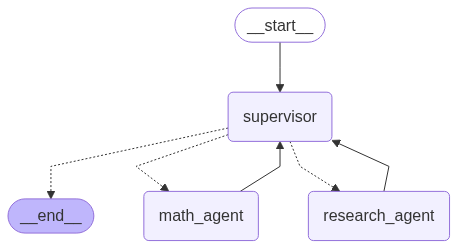

In [20]:
from IPython.display import Image, display

try:
    display(Image(supervisor.get_graph().draw_mermaid_png()))
except Exception:
    pass

## 3. 실행

In [25]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "2024년 미국 전체 GDP와 뉴욕주의 GDP를 찾아줘.그리고 뉴욕주의 GDP가 미국 GDP의 몇 퍼센트인지 `math_agent`로 계산해줘.",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor




Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel is_last_step, ignoring it.
Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel remaining_steps, ignoring it.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

2024년 미국의 GDP는 약 26.4조 달러이며, 뉴욕주의 GDP는 약 1.8조 달러입니다. 뉴욕주의 GDP는 미국 GDP의 약 6.82%입니다.




## 4. 슈퍼바이저 에이전트 처음부터 만들기

이제 동일한 멀티 에이전트 시스템을 처음부터 직접 구현해보겠습니다. 이를 위해 다음과 같은 작업이 필요합니다:

- 감독자(supervisor)가 각 워커 에이전트들과 어떻게 소통할지 설정합니다.
- 감독자 에이전트를 생성합니다.
- 감독자와 워커 에이전트들을 하나의 멀티 에이전트 그래프로 결합합니다.

### 에이전트 간 통신 설정  
감독자 에이전트가 워커 에이전트들과 통신할 수 있는 방식을 정의해야 합니다.  
멀티 에이전트 아키텍처에서 일반적으로 사용하는 방법은 **handoff** 방식입니다. 하나의 에이전트가 제어 권한을 다른 에이전트에게 넘기는 방식입니다.

Handoff를 사용하면 다음을 지정할 수 있습니다:

- **destination**: 제어를 넘길 대상 에이전트  
- **payload**: 해당 에이전트에게 전달할 정보  

우리는 **handoff 도구(handoff tools)** 를 통해 이 기능을 구현할 것이며, 이 도구들을 감독자 에이전트에게 제공합니다.  
감독자가 이러한 도구를 호출하면, 제어 권한을 워커 에이전트에게 넘기고 전체 메시지 히스토리를 함께 전달하게 됩니다.

In [31]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def create_handoff_tool(*, agent_name: str, description: str | None = None):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": name,
            "tool_call_id": tool_call_id,
        }
        # highlight-next-line
        return Command(
            # highlight-next-line
            goto=agent_name,  # (1)!
            # highlight-next-line
            update={**state, "messages": state["messages"] + [tool_message]},  # (2)!
            # highlight-next-line
            graph=Command.PARENT,  # (3)!
        )

    return handoff_tool


# Handoffs
assign_to_research_agent = create_handoff_tool(
    agent_name="research_agent",
    description="Assign task to a researcher agent.",
)

assign_to_math_agent = create_handoff_tool(
    agent_name="math_agent",
    description="Assign task to a math agent.",
)

1. 핸드오프할 에이전트 또는 노드의 이름입니다.
1. 해당 에이전트의 메시지를 부모 상태(parent state)에 추가하여 핸드오프의 일부로 포함시킵니다.다음 에이전트는 부모의 상태를 그대로 이어받아 보게 됩니다.
1. LangGraph에 우리가 상위 멀티 에이전트 그래프의 에이전트 노드로 이동해야 함을 알려줍니다.

### 슈퍼바이저 에이전트 생성

그럼 이제, 방금 정의한 handoff 도구들을 사용하여 **감독자 에이전트(supervisor agent)** 를 만들어봅시다.
우리는 미리 만들어진 `create_react_agent`를 사용할 것입니다.

In [32]:
supervisor_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[assign_to_research_agent, assign_to_math_agent],
    prompt=(
        "당신은 두 개의 전문가 에이전트를 관리하는 감독자입니다:\n"
        "- 리서치 에이전트: 리서치(조사) 관련 작업을 이 에이전트에게 할당하세요\n"
        "- 수학 에이전트: 수학 관련 작업을 이 에이전트에게 할당하세요\n"
        "한 번에 하나의 에이전트에게만 작업을 할당하고, 에이전트를 병렬로 호출하지 마세요.\n"
        "당신 스스로는 어떤 작업도 수행하지 마세요."
    ),
    name="supervisor",
)

### 그래프 구축

이 모든 내용을 종합하여, 전체 멀티 에이전트 시스템을 위한 그래프를 만들어 봅시다.  
감독자(supervisor)와 개별 에이전트들을 서브그래프 노드로 추가할 것입니다.

In [33]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import StateGraph, START, MessagesState


# Define the multi-agent supervisor graph
supervisor = (
    StateGraph(MessagesState)
    # NOTE: `destinations` is only needed for visualization and doesn't affect runtime behavior
    .add_node(supervisor_agent, destinations=("research_agent", "math_agent", END))
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    # always return back to the supervisor
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

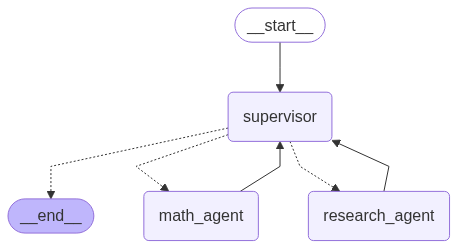

In [35]:
from IPython.display import Image, display

try:
    display(Image(supervisor.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 실행

In [37]:
for chunk in supervisor.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_agent

Successfully transferred to research_agent


Update from node research_agent:


================================== Ai Message ==================================
Name: research_agent

- US GDP in 2024: $29.184 trillion
- New York state GDP in 2024: $2.297 trillion
- Percentage of US GDP that New York state represents: Approximately 7.87%


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The GDP of the United States in 2024 is approximately $29.184 trillion, while the GDP of New York state is about $2.297 trillion. This means that New York state represents approximately 7.87% of the total US GDP.




## 5. 위임 작업(delegation tasks) 생성

지금까지 개별 에이전트들은 전체 메시지 기록을 해석하여 자신의 작업을 파악했습니다.
하지만 이와는 다른 방법으로, 감독자(Supervisor)가 명시적으로 작업(task)을 작성하도록 요청할 수 있습니다.
이를 위해 `handoff_tool` 함수에 `task_description` 매개변수를 추가하면 됩니다.

In [39]:
from langgraph.types import Send


def create_task_description_handoff_tool(
    *, agent_name: str, description: str | None = None
):
    name = f"transfer_to_{agent_name}"
    description = description or f"Ask {agent_name} for help."

    @tool(name, description=description)
    def handoff_tool(
        # this is populated by the supervisor LLM
        task_description: Annotated[
            str,
            "다음 에이전트가 수행해야 할 작업에 대한 설명으로, 모든 관련된 상황(context)을 포함해야 합니다.",
        ],
        # these parameters are ignored by the LLM
        state: Annotated[MessagesState, InjectedState],
    ) -> Command:
        task_description_message = {"role": "user", "content": task_description}
        agent_input = {**state, "messages": [task_description_message]}
        return Command(
            # highlight-next-line
            goto=[Send(agent_name, agent_input)],
            graph=Command.PARENT,
        )

    return handoff_tool


assign_to_research_agent_with_description = create_task_description_handoff_tool(
    agent_name="research_agent",
    description="리서치 에이전트에게 작업을 할당하세요",
)

assign_to_math_agent_with_description = create_task_description_handoff_tool(
    agent_name="math_agent",
    description="수학 에이전트에게 작업을 할당하세요.",
)

supervisor_agent_with_description = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[
        assign_to_research_agent_with_description,
        assign_to_math_agent_with_description,
    ],
    prompt=(
        "당신은 두 개의 전문가 에이전트를 관리하는 감독자입니다:\n"
        "- 리서치 에이전트: 리서치(조사) 관련 작업을 이 에이전트에게 할당하세요\n"
        "- 수학 에이전트: 수학 관련 작업을 이 에이전트에게 할당하세요\n"
        "한 번에 하나의 에이전트에게만 작업을 할당하고, 에이전트를 병렬로 호출하지 마세요.\n"
        "당신 스스로는 어떤 작업도 수행하지 마세요."
    ),
    name="supervisor",
)

supervisor_with_description = (
    StateGraph(MessagesState)
    .add_node(
        supervisor_agent_with_description, destinations=("research_agent", "math_agent")
    )
    .add_node(research_agent)
    .add_node(math_agent)
    .add_edge(START, "supervisor")
    .add_edge("research_agent", "supervisor")
    .add_edge("math_agent", "supervisor")
    .compile()
)

우리는 handoff_tool에서 `Send()`를 사용하고 있습니다. 이는 각 워커 에이전트가 supervisor 그래프의 전체 상태를 입력으로 받는 대신,
Send 페이로드의 내용만을 보게 된다는 것을 의미합니다. 이 예제에서는 작업 설명을 단일 "human" 메시지로 전송하고 있습니다.

In [40]:
for chunk in supervisor_with_description.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "find US and New York state GDP in 2024. what % of US GDP was New York state?",
            }
        ]
    },
    subgraphs=True,
):
    pretty_print_messages(chunk, last_message=True)

Update from subgraph supervisor:


	Update from node agent:


	================================== Ai Message ==================================
	Name: supervisor
	Tool Calls:
	  transfer_to_research_agent (call_9KHSIipcjSIDyOSUq7LdhkHW)
	 Call ID: call_9KHSIipcjSIDyOSUq7LdhkHW
	  Args:
	    task_description: Find the projected GDP of the United States and New York State for the year 2024. Additionally, calculate the percentage of New York State's GDP relative to the total GDP of the United States for that year.


Update from subgraph research_agent:


	Update from node agent:


	================================== Ai Message ==================================
	Name: research_agent
	Tool Calls:
	  tavily_search (call_yM5rpXVQsGd7VIAcUUn6tRbj)
	 Call ID: call_yM5rpXVQsGd7VIAcUUn6tRbj
	  Args:
	    query: projected GDP of the United States 2024
	    search_depth: advanced
	  tavily_search (call_ffSjGDvlOpy84R0K44gAS6Ul)
	 Call ID: call_ffSjGDvlOpy84R0K44gAS6Ul
	  Args:
	    query: projecte